In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Modules**

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add



In [ ]:
BASE_DIR='/content/drive/MyDrive/Deep learning/Image Caption Generator/Data'
WORKING_DIR='/content/drive/MyDrive/Deep learning/Image Caption Generator/Working'

**Extract Image Features**

In [ ]:
# load vgg16 model
model=VGG16()
# restructure the model
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
features={}
directory=os.path.join(BASE_DIR,'images')

for img_name in tqdm(os.listdir(directory)):
  # load the image from file
  img_path=directory+'/'+img_name
  image=load_img(img_path, target_size=(224,224))
  # convert image pixels to numpy array
  image=img_to_array(image)
  #reshape data for model
  image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  #preprocess image for vgg
  image=preprocess_input(image)
  #extract features
  feature=model.predict(image, verbose=0)
  # get image ID
  image_id=img_name.split('.')[0]
  # store feature
  features[image_id]=feature


  0%|          | 0/2289 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'), 'rb') as f:
  features=pickle.load(f)

**Load the Captions Data**

In [ ]:
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
  next(f)
  captions_doc=f.read()

In [ ]:
# create mapping of image to captions
mapping={}
#process lines
for line in tqdm(captions_doc.split('\n')):
  # split the line by comma(,)
  tokens=line.split(',')
  if len(line)<2:
    continue
  image_id, caption=tokens[0], tokens[1:]
  # remove extensions from image ID
  image_id=image_id.split('.')[0]
  # convert caption list to string
  caption=" ".join(caption)
  # create list if needed
  if image_id not in mapping:
    mapping[image_id]=[]
  # store the caption
  mapping[image_id].append(caption)

  0%|          | 0/6002 [00:00<?, ?it/s]

In [ ]:
len(mapping)

1200

**Preprocess Text Dataa**

In [ ]:
def clean(mapping):
  for key,captions in mapping.items():
    for i in range(len(captions)):
      #taking one caption at a time
      caption=captions[i]
      #preprocess steps
      # convert to lowercase
      caption=caption.lower()
      caption = caption.replace('[^A-Za-z]', '')
      # delete additional spaces
      caption = caption.replace('\s+', ' ')
      # add start and end tags to the caption
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption

In [ ]:
mapping['492493570_c27237a396']

['a girl chases a bird across the sand at the edge of the ocean .',
 'a girl in a pink suit chases a gull on a beach .',
 'girl in pink bathing suit with right arm in air behind a seagull on the beach near the water .',
 'the little girl plays along the shoreline as the seagull passes by .',
 'young girl in red bathing suit feeding a seagull']

In [ ]:
clean(mapping)

In [ ]:
mapping['492493570_c27237a396']

['startseq girl chases bird across the sand at the edge of the ocean endseq',
 'startseq girl in pink suit chases gull on beach endseq',
 'startseq girl in pink bathing suit with right arm in air behind seagull on the beach near the water endseq',
 'startseq the little girl plays along the shoreline as the seagull passes by endseq',
 'startseq young girl in red bathing suit feeding seagull endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)


6000

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

3301

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

28

**Train Test Split**

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

**Model Creation**

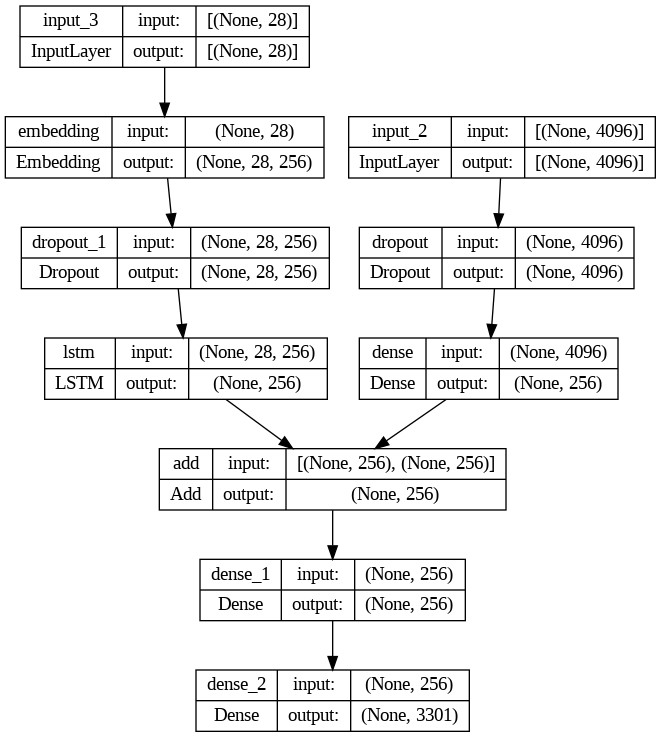

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

33/33 [==============================] - 6s 193ms/step - loss: 1.9516


**Generate Captions for the Image**

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/120 [00:00<?, ?it/s]

BLEU-1: 0.510685
BLEU-2: 0.273358


**Visualize the Results**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq girl chases bird across the sand at the edge of the ocean endseq
startseq girl in pink suit chases gull on beach endseq
startseq girl in pink bathing suit with right arm in air behind seagull on the beach near the water endseq
startseq the little girl plays along the shoreline as the seagull passes by endseq
startseq young girl in red bathing suit feeding seagull endseq
--------------------Predicted--------------------
startseq girl in swimming bathing suit feeding seagull at the edge of the edge endseq


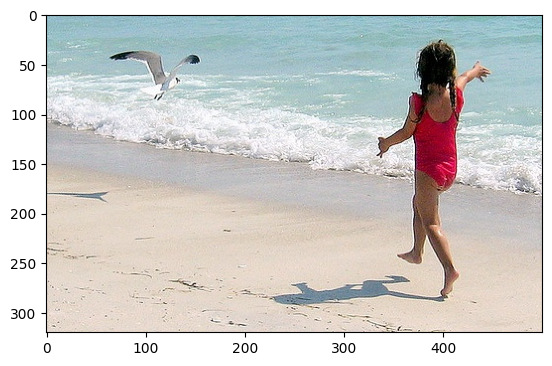

In [ ]:
generate_caption('492493570_c27237a396.jpg')
